# Customer Lifetime Value using the BG/NBD Model
In this project we will use an statistical model BG/NBD to predict future behavior of customers given current purchase history. We will use real user data and find the parameters that maximize the likelihood of the model. We will discuss some advantages and disadvantages of the approach.
- Reference: http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

In [156]:
import pandas as pd
import numpy as np
import pylab as plt
from scipy.special import gamma, gammaln, beta, hyp2f1, factorial
from scipy.optimize import minimize

## Reading and preprocessing the Data
We start with a text file from the original source. I tried using pandas but the format was weird (TODO: try again pandas to read the file). Then we will convert the date column from string to pandas date object. 

In [2]:
f = open('CDNOW_sample/CDNOW_sample.txt')
lDATA = []
for line in f:
    lDATA.append([item for item in line.strip().replace('\n','').split(' ') if len(item)>0])
DATA = np.array(lDATA)

In [13]:
df = pd.DataFrame(DATA,columns=['CustomerID_M','Customer_ID','Date','Quantity','Amount'])
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df.head()

,CustomerID_M,Customer_ID,Date,Quantity,Amount
0,00004,0001,1997-01-01,2,29.33
1,00004,0001,1997-01-18,2,29.73
2,00004,0001,1997-08-02,1,14.96
3,00004,0001,1997-12-12,2,26.48
4,00021,0002,1997-01-01,3,63.34


In [15]:
# counting number of records and unique customers
df.shape, len(np.unique(df['Customer_ID']))

((6919, 5), 2357)

In [16]:
len(np.unique(df['Customer_ID']))

2357

In [21]:
# computing time in from start of experiment
df['t'] = 39 - ((df['Date'] - pd.to_datetime('1996-12-31'))/pd.Timedelta(1, unit='d'))/7

In [18]:
# defining the right period of time 39 weeks after the start of the experiment
df_cal = df[df['Date']<='1997-09-30']

In [223]:
df_pred = df[df['Date']>'1997-09-30']

In [19]:
# Aggregate at the customer level
df_summary = df_cal[['Customer_ID','t']].groupby('Customer_ID')['t'].nunique().reset_index()
df_summary.columns = ['Customer_ID','n']
# compute x: number of transactions in the period T (frequency)
df_summary['x'] = df_summary['n'] - 1

In [20]:
# compute * T: length of the time period during which repeated transaction have occured (T = 39 - time of first purchase)
df_summary['T'] = df_cal[['Customer_ID','t']].groupby('Customer_ID').max().reset_index()['t']

In [26]:
# computing t: time of the last transaction (recency) in weeks
df_summary['t_x'] = df_summary['T'] - df_cal[['Customer_ID','t']].groupby('Customer_ID').min().reset_index()['t']

In [225]:
# Aggregate at the customer level
df_summary_pred = df_pred[['Customer_ID','t']].groupby('Customer_ID')['t'].nunique().reset_index()
df_summary_pred.columns = ['Customer_ID','n']
# compute x: number of transactions in the period T (frequency)
df_summary_pred['x'] = df_summary_pred['n'] - 1
# compute * T: length of the time period during which repeated transaction have occured (T = 39 - time of first purchase)
df_summary_pred['T'] = df_pred[['Customer_ID','t']].groupby('Customer_ID').max().reset_index()['t']
# computing t: time of the last transaction (recency) in weeks
df_summary_pred['t_x'] = df_summary_pred['T'] - df_pred[['Customer_ID','t']].groupby('Customer_ID').min().reset_index()['t']

## Computing LogLikelihood

In [27]:
# Model Parameters, starting point
r = 0.243
alpha = 4.414
a = 0.793
b = 2.426

In [28]:
# Log-likelihood Eqs 6 and 7, [Faber2005]
A1 = gamma(r+df_summary['x'])*np.power(alpha,r)/gamma(r)
logA1 = np.log(A1)
A2 = gamma(a+b)*gamma(b+df_summary['x'])/(gamma(b)*gamma(a+b+df_summary['x']))
logA1 = np.log(A1)
A3 = np.power(alpha + df_summary['T'],-(r + df_summary['x']))
logA1 = np.log(A1)
A4 = (a/(b+df_summary['x']-1))*np.power(alpha + df_summary['t_x'],-(r + df_summary['x']))
logA1 = np.log(A1)
LL = np.sum(np.log(A1*A2*(A3 + np.heaviside(df_summary['x'],0)*A4)))

In [29]:
LL

-9582.430478013672

## Maximizing Log Likelihood
We will use scipy optimization package to find the optimum values of [r, alpha, a,b] to maximize Log Likelihood

In [30]:
# First, define a function for LogLikelihood
def LL(log_params,data):
    #params = [r,alpha,a,b]
    r = np.exp(log_params[0])
    alpha = np.exp(log_params[1])
    a = np.exp(log_params[2])
    b = np.exp(log_params[3])
    A1 = gamma(r+data['x'])*np.power(alpha,r)/gamma(r)
    A2 = gamma(a+b)*gamma(b+data['x'])/(gamma(b)*gamma(a+b+data['x']))
    A3 = np.power(alpha + data['T'],-(r + data['x']))
    A4 = (a/(b+data['x']-1))*np.power(alpha + data['t_x'],-(r + data['x']))
    LL = np.sum(np.log(A1*A2*(A3 + np.heaviside(data['x'],0)*A4)))
    return(LL)

In [213]:
# select relevant data
data = df_summary[['x','T','t_x']]

In [32]:
# scipy optimization package converged and provided an estimate 
res = minimize(fun=lambda params, data: -LL(params, data),x0=np.array([-1, 1, -1, 1]), args=(data,), method='BFGS')

In [35]:
# note that we used logarithm of the parameters to avoid rapid growth in teh optimization calculations
# the values provides are the same as teh ones reported in [Faber2005]
np.exp(res.x)

array([0.24259451, 4.4136015 , 0.79292239, 2.42590795])

In [37]:
[r,alpha,a,b] = np.exp(res.x)

In [126]:
res

      fun: 9582.429206673933
 hess_inv: array([[ 0.00233209,  0.0027738 , -0.00018224, -0.00060782],
       [ 0.0027738 ,  0.00623771, -0.00067924, -0.00035725],
       [-0.00018224, -0.00067924,  0.0033367 , -0.00019081],
       [-0.00060782, -0.00035725, -0.00019081,  0.00413612]])
      jac: array([0.        , 0.        , 0.00012207, 0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 90
      nit: 14
     njev: 18
   status: 2
  success: False
        x: array([-1.41636392,  1.48469102, -0.23202993,  0.88620587])

In [142]:
l_method = ['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']

In [144]:
for method in l_method:
    res = minimize(fun=lambda params, data: -LL(params, data),x0=np.array([-1, 1, -1, 1]), args=(data,), method=method)
    print(method, res.success, res.message)
    print(res.x)
    print("")

Nelder-Mead True Optimization terminated successfully.
[-1.41635192  1.48470578 -0.23199931  0.88624643]

Powell True Optimization terminated successfully.
[-1.43042579  1.44949961 -0.15508055  0.97689876]

CG True Optimization terminated successfully.
[-1.41636374  1.48469134 -0.23203015  0.88620593]

BFGS False Desired error not necessarily achieved due to precision loss.
[-1.41636392  1.48469102 -0.23202993  0.88620587]

L-BFGS-B True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[-1.41636116  1.48469238 -0.23196118  0.88628109]



/var/folders/22/9nvz87t91ylc5tn1tdyzy2y80000gn/T/ipykernel_41524/2718189674.py:8: RuntimeWarning: overflow encountered in power
  A1 = gamma(r+data['x'])*np.power(alpha,r)/gamma(r)


TNC True Local minimum reached (|pg| ~= 0)
[ 6.33375729  3.21568664  6.14011419 -4.59082854]

COBYLA True Optimization terminated successfully.
[-1.41644531  1.48480965 -0.22453917  0.89551352]

SLSQP True Optimization terminated successfully
[-65.35191708  33.06756019   7.88072198  -6.17892826]

trust-constr True `gtol` termination condition is satisfied.
[-1.41636417  1.48469077 -0.23202591  0.88621161]



In [193]:
data.sample(frac = 0.1)

,x,T,t_x
1547,0,30.857143,0.000000
1962,2,29.000000,10.857143
2335,2,27.000000,6.857143
325,0,36.857143,0.000000
394,1,36.428571,4.428571
...,...,...,...
1733,0,30.000000,0.000000
1101,1,33.000000,18.285714
1776,3,29.857143,2.428571
2356,0,27.000000,0.000000


In [216]:
l_pars = []
for frac in np.arange(0.1,1.1,0.1):
    data = df_summary[['x','T','t_x']].sample(frac = frac)
    res = minimize(fun=lambda params, data: -LL(params, data),x0=np.array([-1, 1, -1, 1]), args=(data,), method='CG')
    l_pars.append(np.exp(res.x))

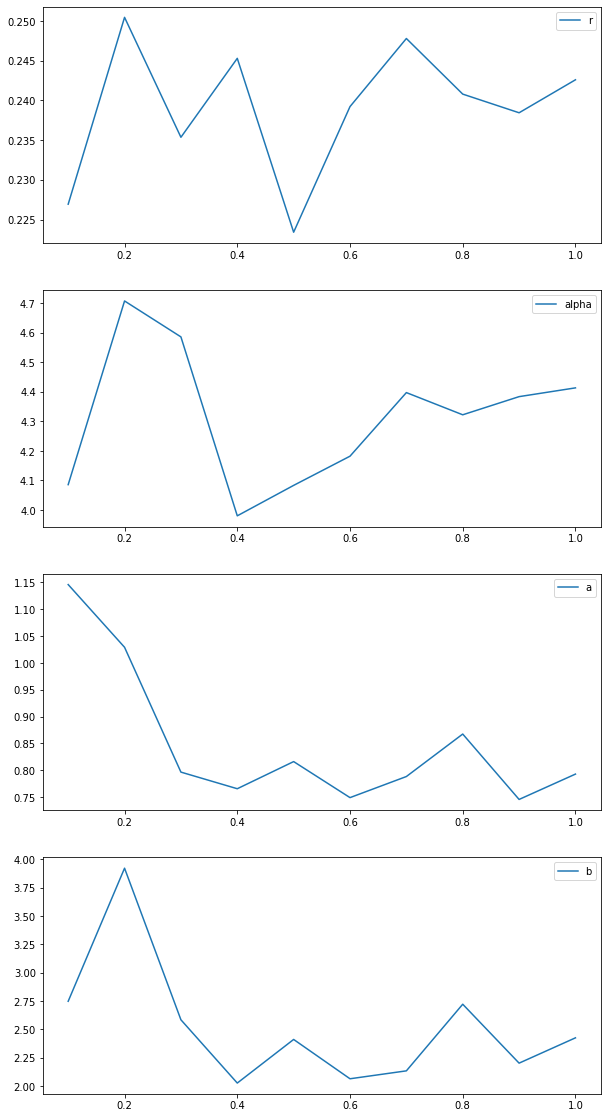

In [222]:
l_pars_names = ['r','alpha','a','b']
fig, axs = plt.subplots(4,figsize = (10,20))
for ii in range(4):
    axs[ii].plot(np.arange(0.1,1.1,0.1),np.array(l_pars).T[ii],label=l_pars_names[ii])
    axs[ii].legend()
plt.savefig('CLV_Optimization_per_data_size.png')

## Model Predictions 
### Expected number of purchases in a a time period t
Using the parameters that we found above and equation 9 we can find the expected number of purchases:

In [145]:
t = np.arange(0,39,1)

In [146]:
EX = (a+b-1)/(a-1)*(1-np.power(alpha/(alpha+t),r)*hyp2f1(r,b,a+b-1,t/(alpha+t)))

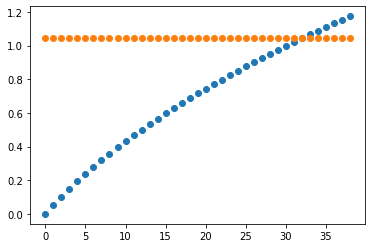

In [147]:
plt.scatter(t,EX)
plt.scatter(t,np.ones(len(t))*df_summary['x'].mean())

### Expected number of future purchases in  a future period t for a customer with history x, t_x and T 

In [148]:
t = np.arange(0,39,0.1)
x = 1
t_x = 1 
T = 1

In [149]:
EY = (((a+b+x-1)/(a-1))*(1-np.power((alpha+T)/(alpha+T+t),(r+x))*hyp2f1(r+x,b+x,a+b+x-1,t/(alpha+T+t))))/(1+np.heaviside(x,0)*(a/(b+x-1))*np.power((alpha+T)/(alpha+t_x),r+x))

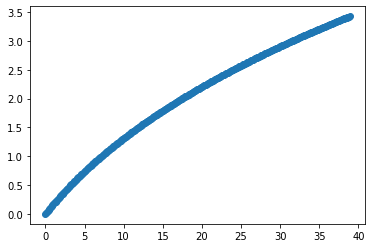

In [150]:
plt.scatter(t,EY)

In [83]:
df_summary.mean()

Customer_ID          inf
n               2.042427
x               1.042427
T              32.715862
t_x             6.845809
dtype: float64

In [117]:
#params = [r,alpha,a,b]
# Model Parameters, starting point
"""
r = 0.243
alpha = 4.414
a = 0.793
b = 2.426
"""
l_r = np.linspace(0,1,100)
l_alpha = np.linspace(4,5,100)
l_a = np.linspace(0,1,100)
l_b = np.linspace(2,3,100)

In [113]:
l_r_alpha = np.meshgrid(l_r,l_alpha)
l_r_ravel = np.ravel(l_r_alpha[0])
l_alpha_ravel = np.ravel(l_r_alpha[1])
l_LL_r_alpha = [LL([l_r_ravel[ii],l_alpha_ravel[ii],0.793,2.426],data) for ii in range(len(l_r_ravel))]
l_LL_r_alpha_reshape = np.array(l_LL_r_alpha).reshape((len(l_r),len(l_r)))

<a list of 9 text.Text objects>

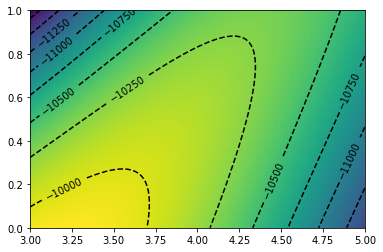

In [114]:
fig, ax = plt.subplots()
plt.scatter(l_alpha_ravel,l_r_ravel,c=l_LL_r_alpha)
CS = plt.contour(l_r_alpha[1],l_r_alpha[0],l_LL_r_alpha_reshape,colors='k')
ax.clabel(CS, inline=True, fontsize=10)

In [115]:
l_r_a = np.meshgrid(l_r,l_a)
l_r_ravel = np.ravel(l_r_a[0])
l_a_ravel = np.ravel(l_r_a[1])
l_LL_r_a = [LL([l_r_ravel[ii],4.414,l_a_ravel[ii],2.426],data) for ii in range(len(l_r_ravel))]
l_LL_r_a_reshape = np.array(l_LL_r_a).reshape((len(l_r),len(l_r)))

<a list of 6 text.Text objects>

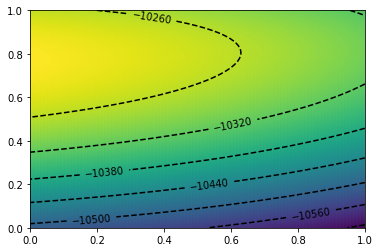

In [116]:
fig, ax = plt.subplots()
plt.scatter(l_a_ravel,l_r_ravel,c=l_LL_r_a)
CS = plt.contour(l_r_a[1],l_r_a[0],l_LL_r_a_reshape,colors='k')
ax.clabel(CS, inline=True, fontsize=10)

In [118]:
l_r_b = np.meshgrid(l_r,l_b)
l_r_ravel = np.ravel(l_r_b[0])
l_b_ravel = np.ravel(l_r_b[1])
l_LL_r_b = [LL([l_r_ravel[ii],4.414,0.793,l_b_ravel[ii]],data) for ii in range(len(l_r_ravel))]
l_LL_r_b_reshape = np.array(l_LL_r_b).reshape((len(l_r),len(l_r)))

<a list of 9 text.Text objects>

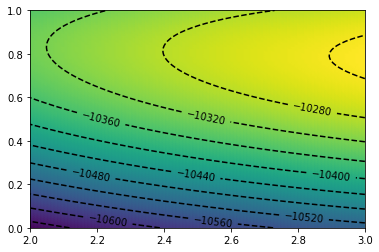

In [121]:
fig, ax = plt.subplots()
plt.scatter(l_b_ravel,l_r_ravel,c=l_LL_r_b)
CS = plt.contour(l_r_b[1],l_r_b[0],l_LL_r_b_reshape,colors='k',levels=10)
ax.clabel(CS, inline=True, fontsize=10)

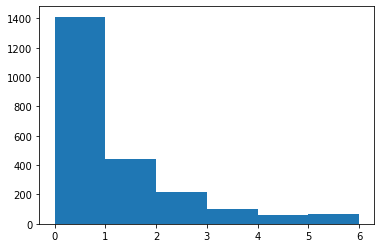

In [155]:
plt.hist(df_summary['x'],range=[0,6],bins=6)
plt.show()

In [167]:
def P(x,t,r,alpha,a,b):
    F1 = beta(a,b+x)/beta(a,b)
    F2 = gamma(r+x)/(gamma(r)*factorial(x))
    F3 = np.power(alpha/(alpha+t),r)
    F4 = np.power(t/(alpha+t),x)
    F5 = beta(a+1,b+x-1)/beta(a,b)
    F6 = np.sum([(gamma(r+j)/(gamma(r)*factorial(j)))*np.power(t/(alpha+t),j) for j in range(x)])
    return(F1*F2*F3*F4 + np.heaviside(x,0)*F5*(1-F3*F6))

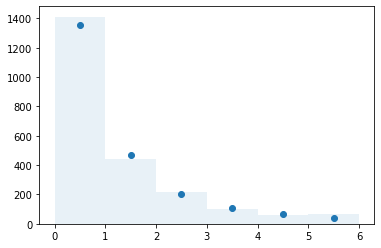

In [179]:
n, bins, _ = plt.hist(df_summary['x'],range=[0,6],bins=6,alpha = 0.1)
plt.scatter([ii+0.5 for ii in range(6)],[P(ii,39,r,alpha,a,b)*len(df_summary) for ii in range(6)])
plt.show()

In [190]:
100.*(np.sum(n) - np.sum([P(ii,39,r,alpha,a,b)*len(df_summary) for ii in range(6)]))/np.sum(n)

2.328913838519278

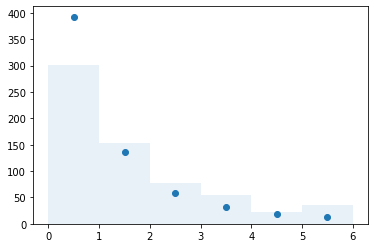

In [227]:
n, bins, _ = plt.hist(df_summary_pred['x'],range=[0,6],bins=6,alpha = 0.1)
plt.scatter([ii+0.5 for ii in range(6)],[P(ii,39,r,alpha,a,b)*len(df_summary_pred) for ii in range(6)])
plt.show()

In [228]:
df_summary_pred['T']

0     -10.428571
1      -3.571429
2     -22.142857
3     -19.000000
4      -6.000000
         ...    
679    -1.857143
680   -20.714286
681   -17.857143
682   -17.714286
683   -13.571429
Name: T, Length: 684, dtype: float64